SQL (Write SQL queries to accomplish this.  When I say 'display' I mean write a select query.)
* Display the first and last name of each actor in a single column in upper case letters.  Name that column "Actor Name"
* Find all actors whose last name contains the letters "LI"
* List the last names of actors, as well as the amount of actors who have that last name
* Display the first name, last name, full address, and total payment amount collected in 2005 for each staff member.
* Display all actors who appear in the film Alone Trip
* What customer had the highest amount of rentals in 2005? Eleanor Hunt
* What store had the highest number of rentals for family movies? Store 1

Python (Use a combination of queries using psycopg2 and pandas code to answer the following)
* Create a graphic to display the top 20 rented films.  Then do the same for the bottom 20

In [2]:
import psycopg2
import pandas as pd 
import matplotlib.pyplot as plt
conn = psycopg2.connect(dbname = "postgres",
                        user= "postgres",
                        password = "password",
                        host = "localhost",
                        port = "5432")

cursor = conn.cursor()

,Title,Rental Count
938,DUCK RACER,6
939,JERSEY SASSY,6
940,TERMINATOR CLUB,6
941,FULL FLATLINERS,5
942,INFORMER DOUBLE,5
943,PRIVATE DROP,5
944,FEVER EMPIRE,5
945,MUSSOLINI SPOILERS,5
946,BRAVEHEART HUMAN,5
947,BUNCH MINDS,5


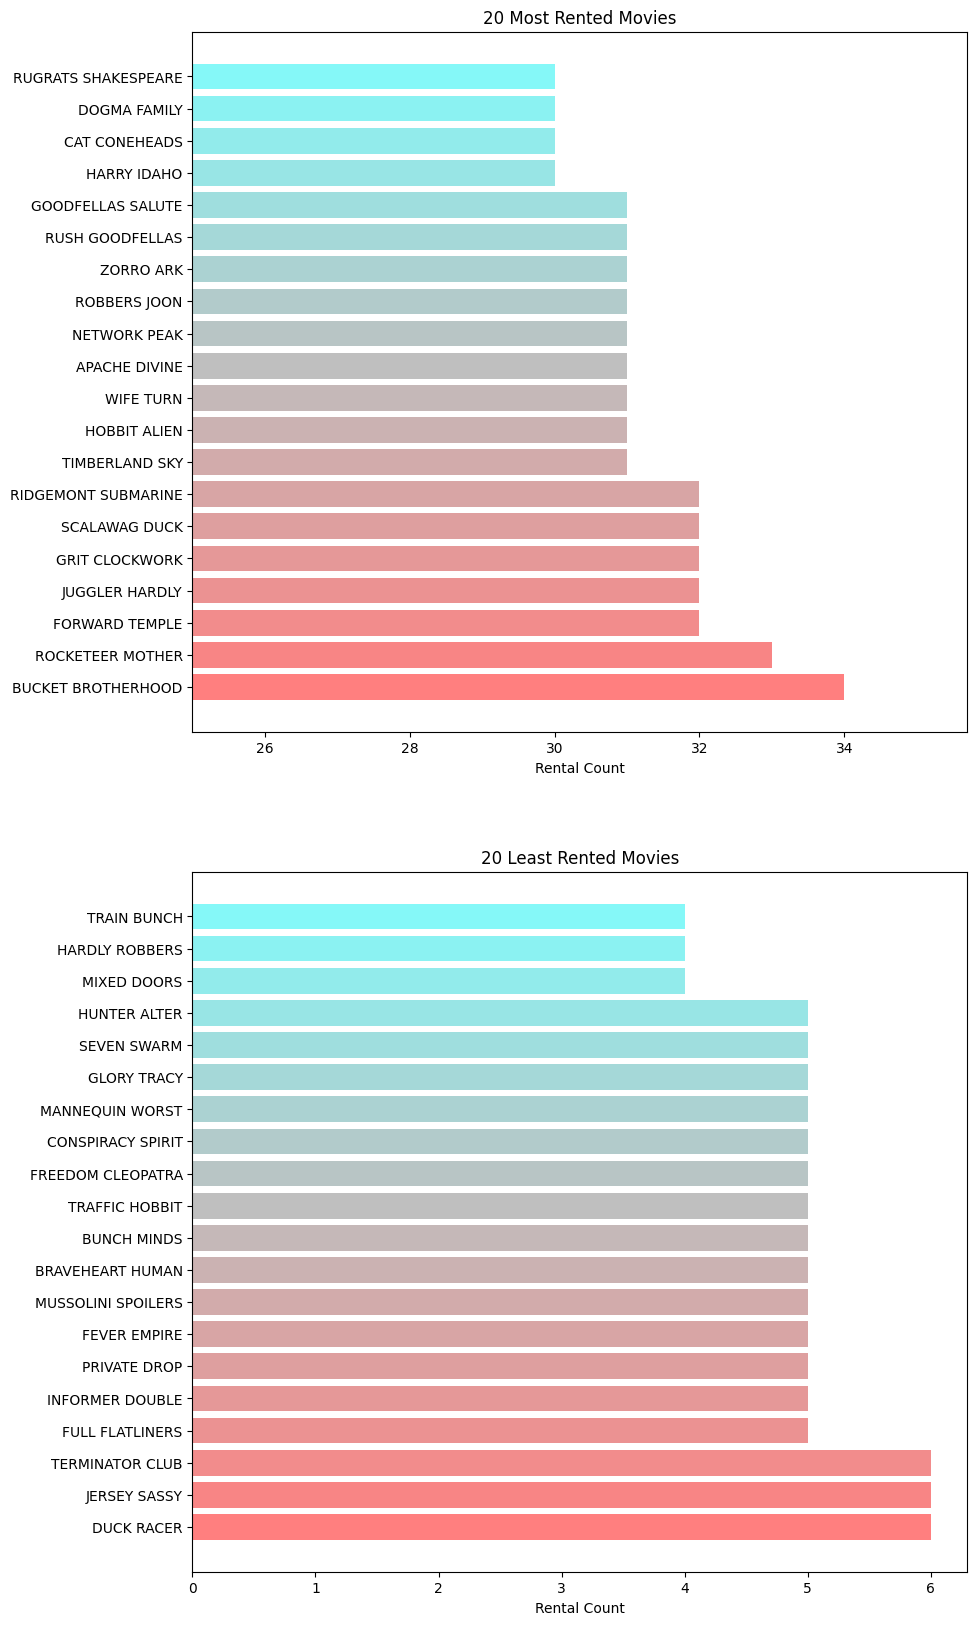

In [137]:
#most rented movie by title 
cursor.execute("""SELECT film.title, COUNT(rental.rental_id) as num_rentals 
               FROM film JOIN inventory ON film.film_id = inventory.film_id 
               JOIN rental on rental.inventory_id = inventory.inventory_id
                GROUP BY title
                ORDER BY num_rentals DESC""")
rows = cursor.fetchall() #return query results
movies_by_rentals = pd.DataFrame(rows)
movies_by_rentals.columns = ["Title", "Rental Count"]
titles = movies_by_rentals["Title"]
rentals = movies_by_rentals["Rental Count"]

#color gradient
clst = []
clength = len(titles[:20])
normalize = plt.Normalize(0, clength)
for i in range(clength):
    clst.append((1-normalize(i), normalize(i), normalize(i), 0.5))


fig, ax = plt.subplots(2, 1, figsize = (10, 20))
ax[0].barh(titles[:20], rentals[:20], color = clst)
ax[0].set_xlabel("Rental Count")
ax[0].set_title("20 Most Rented Movies")
ax[0].set_xlim(xmin = 25)
ax[1].barh(titles[-20:], rentals[-20:], color = clst)
ax[1].set_title("20 Least Rented Movies")
ax[1].set_xlabel("Rental Count")

movies_by_rentals.tail(20)


* Create a graphic that compares the amount of sales each store has brought in.

Text(0.5, 1.0, 'Sales by Store')

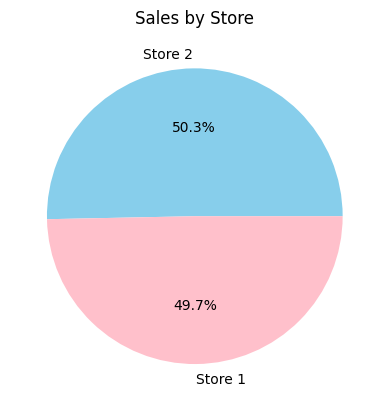

In [21]:
#sales by store
cursor.execute("""SELECT staff.store_id, SUM(payment.amount) as total_sales 
	FROM staff JOIN payment on staff.staff_id = payment.staff_id
	GROUP BY staff.store_id""")
rows = cursor.fetchall()
rental_by_store = pd.DataFrame(rows)
rental_by_store.columns = ["Store ID", "Sales"]

fig, ax = plt.subplots()
ax.pie(rental_by_store["Sales"], labels = [(f"Store {x}") for x in rental_by_store["Store ID"]], autopct='%1.1f%%', colors = ['skyblue', 'pink'])
ax.set_title("Sales by Store")


* Create a python function that will display a graphic the showcases the top N genres by gross revenue.


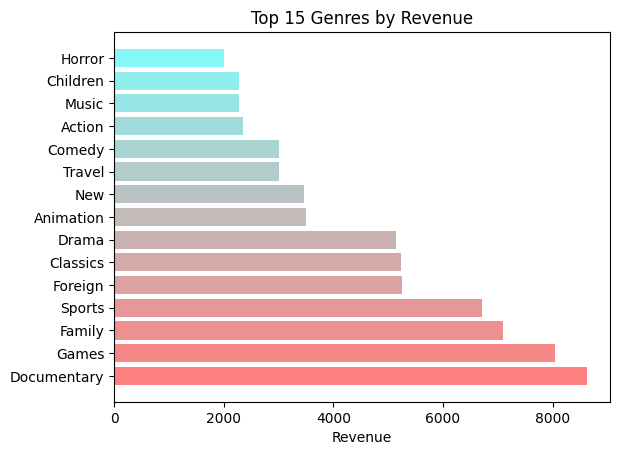

In [58]:
def display_genres(n): 
    if n > 16:
        return ("Too many Genres")
    cursor.execute("""SELECT category.name AS genre, SUM(payment.amount) AS revenue FROM payment JOIN rental on payment.rental_id = rental.rental_id JOIN inventory on rental.inventory_id = inventory.inventory_id JOIN film_category ON inventory.film_id = film_category.category_id JOIN category ON film_category.category_id = category.category_id GROUP BY genre ORDER BY revenue DESC""")
    rows = cursor.fetchall()
    genres_df = pd.DataFrame(rows)
    genres_df.columns = ["Genre", "Revenue"]
    n_genres = genres_df["Genre"][:n]
    n_revenues = genres_df["Revenue"][:n]
    #color gradient 
    clst = []
    clength = len(n_genres)
    normalize = plt.Normalize(0, clength)
    for i in range(clength): clst.append((1-normalize(i), normalize(i), normalize(i), 0.5))

    #plot
    fig, ax = plt.subplots()
    ax.barh(n_genres, n_revenues, color = clst)
    ax.set_xlabel("Revenue")
    ax.set_title(f"Top {n} Genres by Revenue")
    plt.plot()

display_genres(15)

* Create a graphic showing the average replacement cost by category

Text(0.5, 1.0, 'Avg. Replacement Cost by Genre')

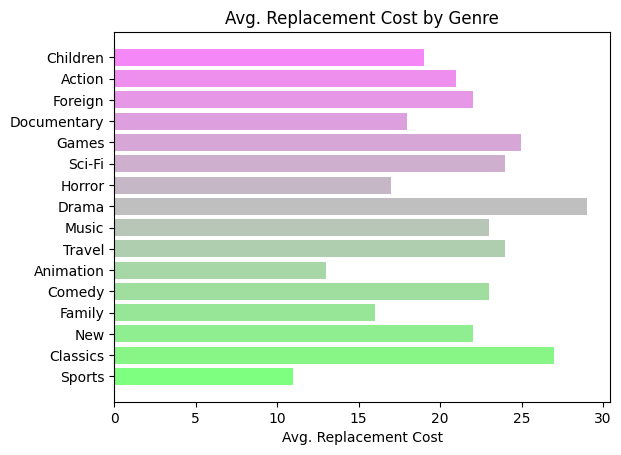

In [41]:
cursor.execute("""SELECT category.name AS genre, AVG(film.replacement_cost) as avg_replacement_cost
	FROM film JOIN film_category ON film.film_id = film_category.category_id
	JOIN category ON film_category.category_id = category.category_id
	GROUP BY genre""")
rows = cursor.fetchall()
replacement_cost_df = pd.DataFrame(rows)
replacement_cost_df.columns = ["Genre", "Avg. Replacement Cost"]
genres = replacement_cost_df["Genre"]
avgcosts = replacement_cost_df["Avg. Replacement Cost"]

clst = []
clength = len(genres)
normalize = plt.Normalize(0, clength)
for i in range(clength): clst.append((normalize(i), 1-normalize(i), normalize(i), 0.5))

fig,ax = plt.subplots()
ax.barh(genres, avgcosts, color = clst)
ax.set_xlabel("Avg. Replacement Cost")
ax.set_title("Avg. Replacement Cost by Genre")




* Create a pie chart showing the percentage of films in each rating category (G, PG, PG-13, etc.)


Text(0.5, 1.0, 'Ratings Distribution by Film Count')

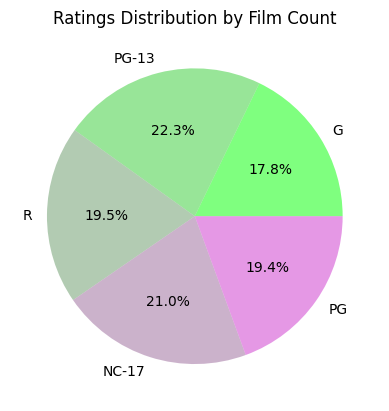

In [46]:
cursor.execute("""SELECT rating, COUNT(film_id) AS films
	FROM film
	GROUP BY rating""")
rows = cursor.fetchall()
ratings_df = pd.DataFrame(rows)
ratings_df.columns = ["Rating", "Films"]
ratings = ratings_df["Rating"]
films = ratings_df["Films"]

clst = []
clength = len(ratings)
normalize = plt.Normalize(0, clength)
for i in range(clength): clst.append((normalize(i), 1-normalize(i), normalize(i), 0.5))

fig, ax = plt.subplots()
ax.pie(films, labels = ratings, autopct='%1.1f%%', colors = clst)
plt.title("Ratings Distribution by Film Count")

* For each category, on average how many rentals of a film need to occur to cover the replacement cost?

In [57]:
cursor.execute("""SELECT category.name AS genre, AVG(payment.amount) as avg_rental, AVG(film.replacement_cost) as avg_replacement_cost
	FROM payment JOIN rental on payment.rental_id = rental.rental_id
	JOIN inventory on rental.inventory_id = inventory.inventory_id
	JOIN film ON inventory.film_id = film.film_id
	JOIN film_category ON film.film_id = film_category.category_id
	JOIN category ON film_category.category_id = category.category_id
	GROUP BY genre""")
rows = cursor.fetchall()
rentals_df = pd.DataFrame(rows)
rentals_df.columns = ["Genre", "Avg. Rental Cost", "Avg. Replacement Cost"]

rentals_df["Rentals To Cover Replacement"] = [round(y/x, 2) for x, y in zip (rentals_df["Avg. Rental Cost"], rentals_df["Avg. Replacement Cost"])]

display(rentals_df)


,Genre,Avg. Rental Cost,Avg. Replacement Cost,Rentals To Cover Replacement
0,Sports,4.1263636363636364,10.9900000000000000,2.66
1,Classics,3.9900000000000000,26.9900000000000000,6.76
2,New,6.1011111111111111,21.9900000000000000,3.60
3,Family,5.7122222222222222,15.9900000000000000,2.80
4,Comedy,4.3233333333333333,22.9900000000000000,5.32
5,Animation,7.5614285714285714,12.9900000000000000,1.72
6,Travel,3.7757142857142857,23.9900000000000000,6.35
7,Music,1.7207692307692308,22.9900000000000000,13.36
8,Drama,5.5233333333333333,28.9900000000000000,5.25
9,Horror,1.4900000000000000,16.9900000000000000,11.40


Analysis
* The owner of these rental stores is working on making an infographic to share with investors that will showcase how each store is doing financially.  She wants you to create at least 4 graphics that she can include in her presentation that will be relevant to her.  These graphics should be designed to provide a clear, concise, and visually appealing overview of how the stores are doing.

Text(0.5, 0, 'Store ID')

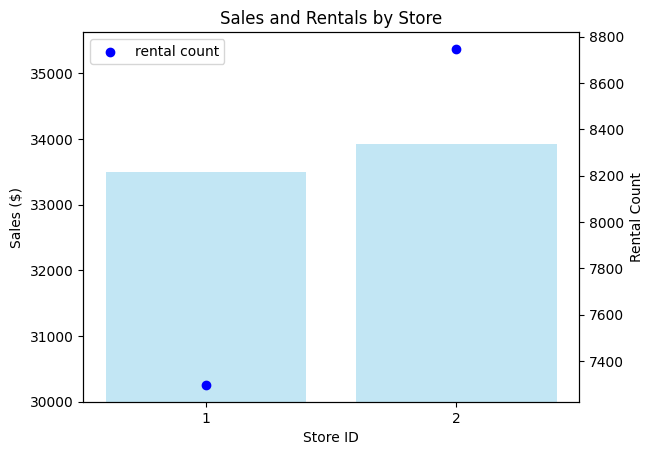

In [74]:
#sales and number of rentals
cursor.execute("""SELECT staff.store_id, SUM(payment.amount) as total_sales 
	FROM staff JOIN payment on staff.staff_id = payment.staff_id
	GROUP BY staff.store_id""")
rows = cursor.fetchall()
sales_by_store = pd.DataFrame(rows)
sales_by_store.columns = ["Store ID", "Sales"]
stores = sales_by_store["Store ID"]
sales = sales_by_store["Sales"]


cursor.execute("""SELECT customer.store_id, COUNT(rental.rental_id) AS num_rentals 
               FROM rental JOIN customer ON rental.customer_id = customer.customer_id
               GROUP BY customer.store_id""")
rows = cursor.fetchall()
rentals_by_store = pd.DataFrame(rows)
rentals_by_store.columns = ["Store ID", "Rentals"]
rentals = rentals_by_store["Rentals"]

fig,ax = plt.subplots()

ax.bar(stores, sales, color = 'skyblue', alpha = 0.5)
ax.set_ylabel("Sales ($)")
ax.set_ylim(ymin = 30000)
ax.set_xlabel("Store ID")
ax2 = ax.twinx()
ax2.scatter(stores, rentals, marker = "o", label = "rental count", color = 'b')
ax2.set_ylabel("Rental Count")

ax.set_xticks(stores)
plt.title("Sales and Rentals by Store")
plt.legend()
plt.xlabel("Store ID")

Text(0.5, 0, 'Month')

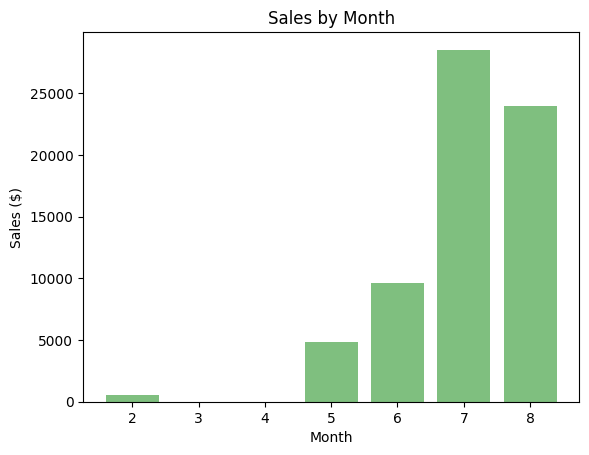

In [89]:
#sales by month
cursor.execute("""SELECT EXTRACT(MONTH FROM(rental.rental_date)) as month, SUM(payment.amount)
	FROM rental JOIN payment ON rental.rental_id = payment.rental_id
	GROUP BY month
	ORDER BY month ASC""")
rows = cursor.fetchall()
sales_by_month = pd.DataFrame(rows)
sales_by_month.columns = ["Month", "Sales"]
month = sales_by_month["Month"]
sales = sales_by_month["Sales"]
#plot
fig, ax = plt.subplots()
ax.bar(month,sales, color = 'g', alpha = 0.5)
ax.set_title("Sales by Month")
ax.set_ylabel("Sales ($)")
ax.set_xlabel("Month")


/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_25619/1280364786.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  f"Total Sales: {float(running_total[-1:])}",


,Date,Sales,Total to Date
0,2022-02-14,514.18,514.18
1,2022-05-24,77.84,592.02
2,2022-05-25,561.62,1153.64
3,2022-05-26,731.32,1884.96
4,2022-05-27,720.26,2605.22


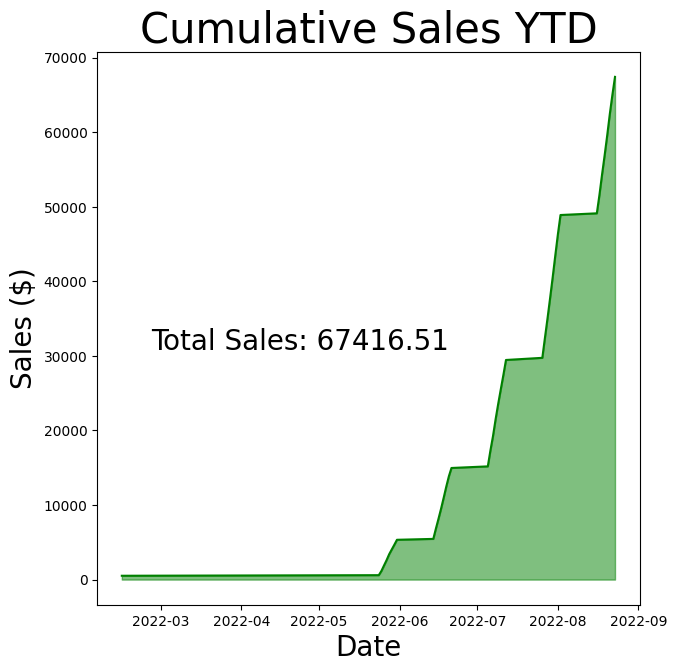

In [138]:
#daily sales
cursor.execute("""SELECT DATE(rental.rental_date) as date, SUM(payment.amount) as daily_total 
	FROM rental JOIN payment ON rental.rental_id = payment.rental_id
	GROUP by date
	ORDER BY date ASC""")


rows = cursor.fetchall()
sales_by_date = pd.DataFrame(rows)
sales_by_date.columns = ["Date", "Sales"]
dates = sales_by_date["Date"]
daily_sales = sales_by_date["Sales"]
sales_by_date["Total to Date"] = [sum(daily_sales[:i+1]) for i in range(len(daily_sales))]
running_total = sales_by_date["Total to Date"]

fig, ax = plt.subplots(figsize = (7,7))

ax.plot(dates,running_total, color = 'g')
ax.fill_between (dates, running_total, color = 'g', alpha = 0.5)
ax.set_title("Cumulative Sales YTD", fontsize = 30)
ax.set_ylabel("Sales ($)", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
plt.text(0.1, 0.5, 
         f"Total Sales: {float(running_total[-1:])}", 
         transform=ax.transAxes, 
         horizontalalignment = 'left', verticalalignment = 'top',
         fontsize = 20)
plt.subplots_adjust(right=0.9, top = 0.9)



sales_by_date.head()


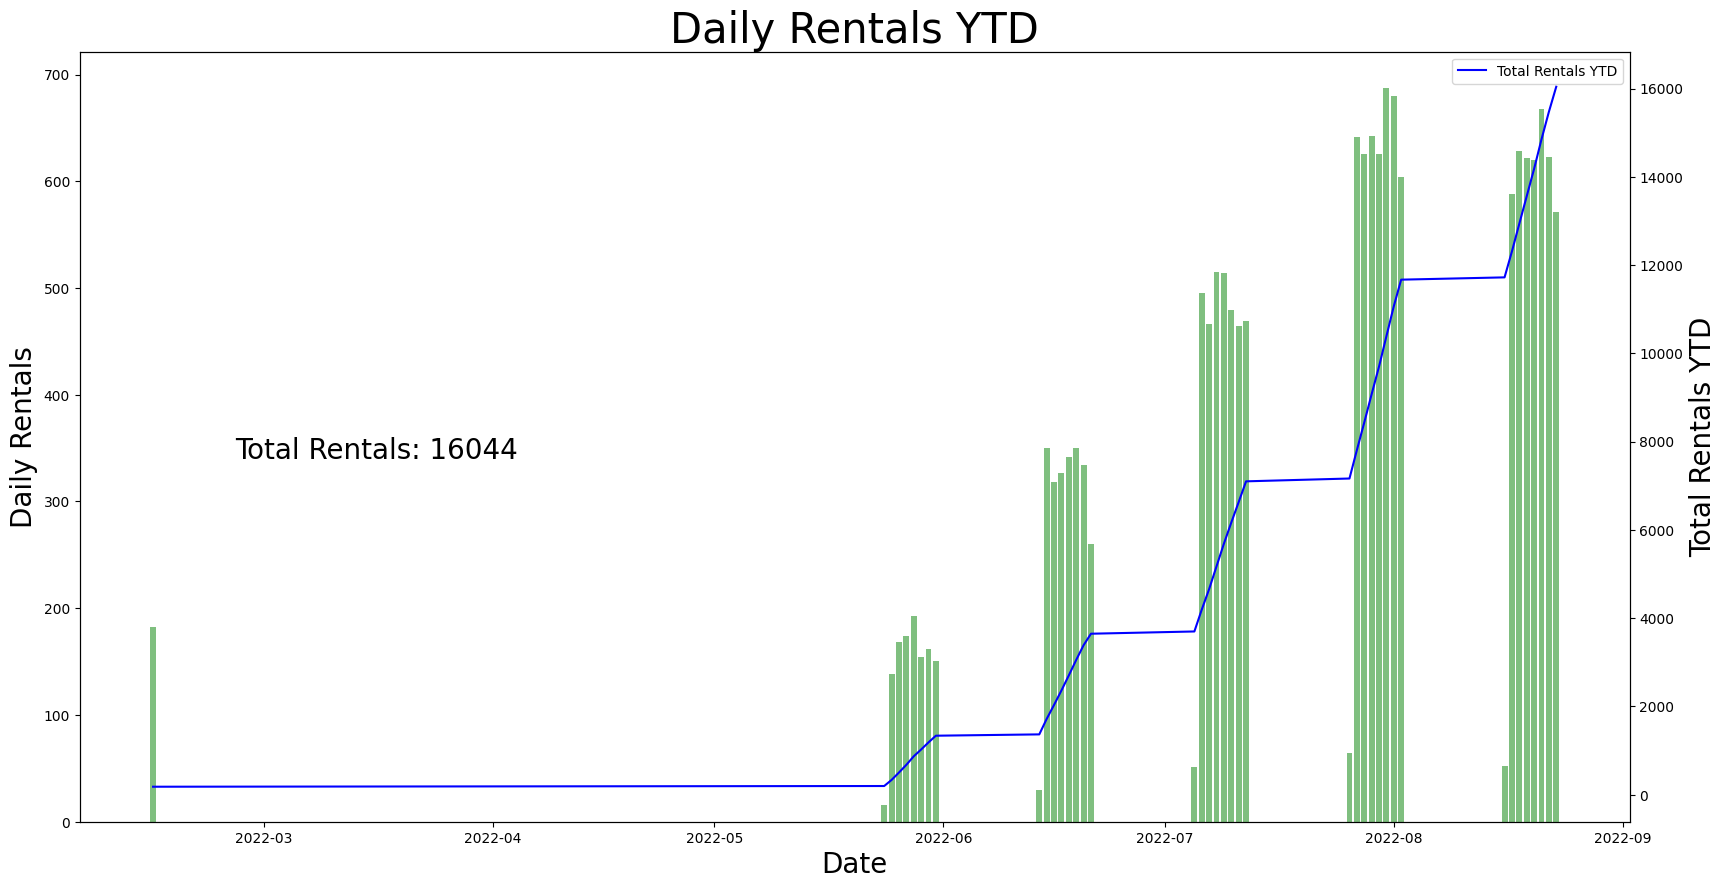

In [158]:
#rentals / month

cursor.execute("""SELECT DATE(rental.rental_date) as date, COUNT(rental.rental_id) as daily_rentals
	FROM rental
	GROUP BY date
	ORDER BY date ASC""")

rows = cursor.fetchall()
rentals_by_date = pd.DataFrame(rows)
rentals_by_date.columns = ["Date", "Rentals"]
dates = rentals_by_date["Date"]
rentals = rentals_by_date["Rentals"]
running_total = [sum(rentals[:i+1]) for i in range(len(rentals))]


fig, ax = plt.subplots(figsize= (20,10))
ax.bar(dates, rentals, color = 'g', alpha = 0.5, label = "Daily Rentals")
ax.set_ylabel("Daily Rentals", fontsize = 20)
ax2 = ax.twinx()
ax2.plot(dates, running_total, color = 'b', label = "Total Rentals YTD")
ax2.set_ylabel("Total Rentals YTD", fontsize = 20)
ax.set_xlabel("Date", fontsize =20)

plt.text(0.1, 0.5, 
         f"Total Rentals: {(running_total[-1])}", 
         transform=ax.transAxes, 
         horizontalalignment = 'left', verticalalignment = 'top',
         fontsize = 20)
plt.title("Daily Rentals YTD", fontsize = 30)
plt.legend()


